In [16]:
#First, we'll import the relevant libraries for our stock forecasting. Most notably, the Pandas Datareader is vital for using the finance API.

In [19]:
#!pip install numpy==1.19.5
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt
import os
!pip install pandas_datareader --upgrade

#NN work best with data preprocessed to values between 0-1 or -1-1, so use this.
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential

In [20]:
start = dt.datetime(2016,1,1)
end = dt.datetime.now()
#Read crypto data from yahoo API
data = web.DataReader(f'{crypto}-{fiat}', 'yahoo', start, end)

In [21]:
#check data
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-12-13,11.507300,11.0188,11.474800,11.503200,296217,11.503200
2017-12-14,11.804200,10.9543,11.483200,11.481600,391397,11.481600
2017-12-15,13.001400,11.1526,11.480900,12.900500,653202,12.900500
2017-12-16,21.955000,12.8705,12.900500,20.495501,2137330,20.495501
2017-12-17,20.502399,17.8407,20.502399,19.435400,624487,19.435400


### minmax scaler

Next we'll be using a MinMax Scaler to normalize the data. The Formula used in MinMax Scaling is shown below. 

$ Xsc=\dfrac{X−Xmin}{Xmax−Xmin} $

The MinMax Scaler works by scaling data to a fixed range, generally zero to one (as we're using here). This will give us much smaller standard deviations than standardization, which will supress the effects of outliers on our analysis of a very volatile crypto currency.

After this, we'll set the number of days out we're planning to predict based on. I tend to be a more careful trader, so I'll set the days to train on at 180 days.

We'll then set the number of days we want to predict in the future, I'll keep it around 90.

In [22]:
#Scale everything within 0-1 range as said earlier.
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

#Decide how many days to base prediction on, older = more conservative.
prediction_days = 60

x_train, y_train = [], []

We'll next fill our training data by iteration over our prediction days, and appending the scaled data as we do so. 

In [23]:
for x in range(prediction_days, len(scaled_data)):
  x_train.append(scaled_data[x-prediction_days:x, 0])
  y_train.append(scaled_data[x,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

Now, we'll construct a Neural Network using a sequential model. Unlike other models, a sequential model works by stacking neurons on top of each other, and activating them one at a time (the default operation being a linear activation function.

The sequential model uses this formula.

$$h(x)=
\sum_{i=1}^n
(θ ix i)$$

𝑥₁ is our number of flats, and 0₁ represents our initial random weight. Our bias is 𝑥₀, and our initial random weight is 0₀.

The next aspect of the model is our loss function, which gives us a value showing how well our model fits the training data. Our goal is to minimize the value of the loss function by returning by adjusting the weights accordingly.

$$h(x)=θ₀+θ₁x₁$$

 The last model is the Mean Squared Error (MSE), which we compute using this formula.

$$MSE = \frac{1}{n} \sum_{i=1}^{n}(Y_i - \hat{Y}_i)^2MSE= n1∑ 
i=1n(Yi−Y^i)2$$

The MSE is meant to give us the averaged squared difference between the actual value and the estimated value. Our number of predictions, 𝑛, taken from 𝑛 amounts of data points give us. 𝑌 is our predicted values, and Ŷ is our predicted values.

Within our sequential model, we'll implement Long short-term memory (LSTM). LSTM is a recurrent neural network (RNN). LSTM has feedback connections, unlike standard neural networks, which are feeed forward. LSTMs have proven invaluable in working with time series data, especially market forecasting, with most top performing models using LSTM to some degree.

\begin{aligned}f_{t}&=\sigma _{g}(W_{f}x_{t}+U_{f}h_{t-1}+b_{f})\\i_{t}&=\sigma _{g}(W_{i}x_{t}+U_{i}h_{t-1}+b_{i})\\o_{t}&=\sigma _{g}(W_{o}x_{t}+U_{o}h_{t-1}+b_{o})\\{\tilde {c}}_{t}&=\sigma _{c}(W_{c}x_{t}+U_{c}h_{t-1}+b_{c})\\c_{t}&=f_{t}\circ c_{t-1}+i_{t}\circ {\tilde {c}}_{t}\\h_{t}&=o_{t}\circ \sigma _{h}(c_{t})\end{aligned}

In the above formula, the lowercase variables represent vectors. Matrices Wᵩ and Uᵩ contain, respectively, the weights of the input and recurrent connections, where the subscript ᵩ can either be the input gate *i*, output gate *o*, the forget gate *f* or the memory cell *c*, depending on the activation being calculated. In this section, we are thus using a "vector notation". 

We'll also introduce a dropout function to stop overfitting. For model estimation, we minimize a loss function by looking at the ordinary least square loss.

$$E_{D} = \dfrac{1}{2} (t-\sum_{i=1}^n \delta_{t}^i w_{i} I_{i})^2$$


Here, the dropout rate is 𝛿, with 𝛿 ~ Bernoulli(p). 

The backpropagation for network training uses a gradient descent approach. To do that, we'll first look at the gradient of the dropout network.

$$\frac{\partial E_{D}}{\partial w_{i}} = -t\delta_{i}I_{i}+w_{i}^2I_{i}^2+ \sum_{j=1,j\neq1}^2 w_{j}\delta_{i}\delta_{j}I_{i}I_{j}$$

To find the relationship between this gradient and the gradient of the regular network, we can make w’ = p*w in the normal for an ordinary least square loss. Therefore,


$$E_{N} = \dfrac{1}{2} (t-\sum_{i=1}^n p_{i} w_{i} I_{i})^2$$

With the derivitive of this we find,


$$\frac{\partial E_{N}}{\partial w_{i}} = -tp_{i}I_{i}+w_{i}p_{i}^2I_{i}^2 + \sum_{j=1,j\neq1}^n w_{j}p_{i}p_{j}I_{i}I_{j}$$

Finally, we have the gradient of the dropout network,


$$E[\frac{\partial E_{D}}{\partial w_{i}}] = -tp_{i}I_{i}+w_{i}p_{i}^2I_{i}^2 + w_{j}Var(\delta_{i}I_{i})^2+\sum_{j=1,j\neq1}^n w_{j}p_{i}p_{j}I_{i}I_{j}$$
$$=$$

$$=\frac{\partial E_{N}}{\partial w_{i}} + w_{i}Var(\delta_{i})I_{i}^2$$

$$=\frac{\partial E_{N}}{\partial w_{i}} + w_{i}p_{i}(1-p_{i})I_{i}^2$$

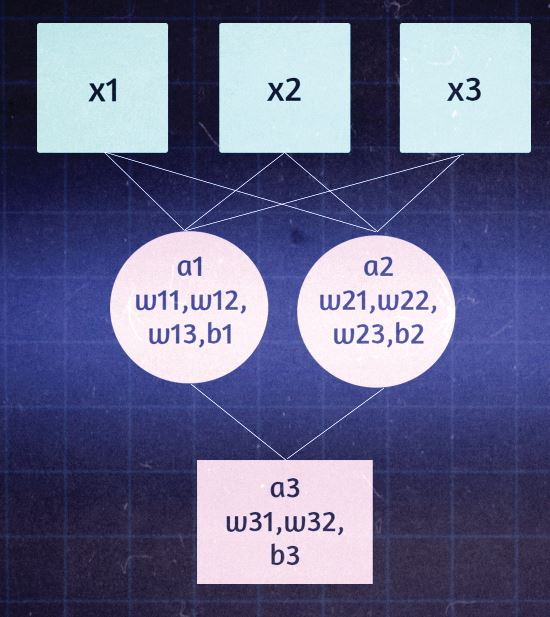

In [24]:
#Create NN
#Possibly downgrade Numpy if it doesn't work (1.19.5)

model = tf.keras.Sequential()
#add LSTM layers

model.add(LSTM(units = 50, 
               return_sequences = True, 
               input_shape = (x_train.shape[1],1)
               ))

model.add(tf.keras.layers.Dropout(0.2))
model.add(LSTM(units=50, return_sequences = True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(LSTM(units = 50))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train, 
          y_train, 
          epochs = 25,
          #validation_data=(validation_inputs, validation_targets),
          batch_size = 32)

Epoch 1/25
51/51 [==============================] - 5s 32ms/step - loss: 0.0073
Epoch 2/25
51/51 [==============================] - 2s 32ms/step - loss: 0.0027
Epoch 3/25
51/51 [==============================] - 2s 31ms/step - loss: 0.0021
Epoch 4/25
51/51 [==============================] - 2s 32ms/step - loss: 0.0021
Epoch 5/25
51/51 [==============================] - 2s 31ms/step - loss: 0.0020
Epoch 6/25
51/51 [==============================] - 2s 32ms/step - loss: 0.0016
Epoch 7/25
51/51 [==============================] - 2s 32ms/step - loss: 0.0018
Epoch 8/25
51/51 [==============================] - 2s 32ms/step - loss: 0.0017
Epoch 9/25
51/51 [==============================] - 2s 31ms/step - loss: 0.0015
Epoch 10/25
51/51 [==============================] - 2s 32ms/step - loss: 0.0013
Epoch 11/25
51/51 [==============================] - 2s 32ms/step - loss: 0.0016
Epoch 12/25
51/51 [==============================] - 2s 32ms/step - loss: 0.0014
Epoch 13/25
51/51 [==================

30/30 [==============================] - 1s 10ms/step


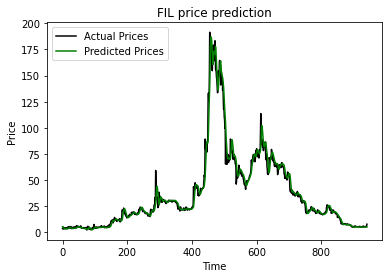

In [25]:
# Testing the Model

test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = web.DataReader(f'{crypto}-{fiat}', 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.fit_transform(model_inputs)

x_test = []

for x in range(prediction_days, len(model_inputs)):
  x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

plt.plot(actual_prices, color='black', label='Actual Prices')
plt.plot(prediction_prices, color='green', label='Predicted Prices')
plt.title(f'{crypto} price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

In [26]:
# Predict next day

real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs)+1,0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

#real_data = real_data.transform(59).reshape((60))
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(prediction)

1/1 [==============================] - 1s 759ms/step
[[5.490042]]
